In [47]:
import argparse
import os
import torch
import pyro
import json
import math
from tqdm import tqdm
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import PyroOptim
from pyro.optim import Adam
import pyro.distributions as dist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import get_cmap
from scipy.sparse import csr_matrix
from scipy.spatial import KDTree
import seaborn as sns

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import lightning as L
import torch.nn.functional as F
from torch.utils.data import DataLoader

import subprocess
import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import GPUtil

In [48]:
if torch.cuda.is_available():
    print("YAY! GPU available :3")
    
    # Get all available GPUs sorted by memory usage (lowest first)
    available_gpus = GPUtil.getAvailable(order='memory', limit=1)
    
    if available_gpus:
        selected_gpu = available_gpus[0]
        
        # Set the GPU with the lowest memory usage
        torch.cuda.set_device(selected_gpu)
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        
        print(f"Using GPU: {selected_gpu} with the lowest memory usage.")
    else:
        print("No GPUs available with low memory usage.")
else:
    print("No GPU available :(")

YAY! GPU available :3
Using GPU: 5 with the lowest memory usage.


In [49]:
def prepare_DLPFC_data(
    section_id=151670,
    num_pcs=5,
    log_normalize=True,
):
    section = ad.read_h5ad(f"data/DLPFC/{section_id}.h5ad")
    section.var["feature_name"] = section.var.index

    spatial_locations = section.obs[["array_row", "array_col"]]
    spatial_locations.columns = ["row", "col"]

    clustering = XeniumCluster(data=section.X, dataset_name="DLPFC")
    clustering.xenium_spot_data = section
    if log_normalize:
        clustering.xenium_spot_data.X = np.log1p(clustering.xenium_spot_data.X)

    clustering.pca(clustering.xenium_spot_data, num_pcs)
    data = clustering.xenium_spot_data.obsm["X_pca"]

    return data, spatial_locations, clustering

def prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=100, 
        third_dim=False, 
        log_normalize=True,
        likelihood_mode="PCA",
        num_pcs=5,
        hvg_var_prop=0.5,
        min_expressions_per_spot=10
    ):

    data_filepath = f"data/spot_data/{dataset}/hBreast_SPOTSIZE={spot_size}um_z={third_dim}.h5ad"
    
    if spots:

        if os.path.exists(data_filepath):

            clustering = XeniumCluster(data=None, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)
            print("Loading data.")
            clustering.xenium_spot_data = ad.read_h5ad(data_filepath)

        else:

            # Path to your .gz file
            file_path = f'data/{dataset}/transcripts.csv.gz'

            # Read the gzipped CSV file into a DataFrame
            df_transcripts = pd.read_csv(file_path, compression='gzip')
            df_transcripts["error_prob"] = 10 ** (-df_transcripts["qv"]/10)
            df_transcripts.head(), df_transcripts.shape

            # drop cells without ids
            df_transcripts = df_transcripts[df_transcripts["cell_id"] != -1]

            # drop blanks and controls
            df_transcripts = df_transcripts[~df_transcripts["feature_name"].str.startswith('BLANK_') & ~df_transcripts["feature_name"].str.startswith('NegControl')]

            clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
            clustering.set_spot_size(spot_size)

            if not os.path.exists(data_filepath):
                print("Generating and saving data")
                clustering.create_spot_data(third_dim=third_dim, save_data=True)
                clustering.xenium_spot_data.write_h5ad(data_filepath)

        print("Number of spots: ", clustering.xenium_spot_data.shape[0])
        clustering.xenium_spot_data = clustering.xenium_spot_data[clustering.xenium_spot_data.X.sum(axis=1) > min_expressions_per_spot]
        print("Number of spots after filtering: ", clustering.xenium_spot_data.shape[0])

        if log_normalize:
            clustering.normalize_counts(clustering.xenium_spot_data)

        if likelihood_mode == "PCA":
            clustering.pca(clustering.xenium_spot_data, num_pcs)
            data = clustering.xenium_spot_data.obsm["X_pca"]
        elif likelihood_mode == "HVG":
            min_dispersion = torch.distributions.normal.Normal(0.0, 1.0).icdf(hvg_var_prop)
            clustering.filter_only_high_variable_genes(clustering.xenium_spot_data, flavor="seurat", min_mean=0.0125, max_mean=1000, min_disp=min_dispersion)
            clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]
            data = clustering.xenium_spot_data.X
        elif likelihood_mode == "ALL":
            data = clustering.xenium_spot_data.X

        spatial_locations = clustering.xenium_spot_data.obs[["row", "col"]]
    
    # prepare cells data
    else:

        cells = df_transcripts.groupby(['cell_id', 'feature_name']).size().reset_index(name='count')
        cells_pivot = cells.pivot_table(index='cell_id', 
                                        columns='feature_name', 
                                        values='count', 
                                        fill_value=0)
        
        location_means = df_transcripts.groupby('cell_id').agg({
            'x_location': 'mean',
            'y_location': 'mean',
            'z_location': 'mean'
        }).reset_index()

        cells_pivot = location_means.join(cells_pivot, on='cell_id')

        if log_normalize:
            # log normalization
            cells_pivot.iloc[:, 4:] = np.log1p(cells_pivot.iloc[:, 4:])

        if likelihood_mode == "PCA":
            pca = PCA(n_components=num_pcs)
            data = pca.fit_transform(cells_pivot.iloc[:, 4:])

        elif likelihood_mode == "HVG":
            genes = cells_pivot.iloc[:, 4:]
            gene_variances = genes.var(axis=0)
            gene_variances = gene_variances.sort_values(ascending=False)
            gene_var_proportions = (gene_variances / sum(gene_variances))
            relevant_genes = list(gene_var_proportions[(gene_var_proportions.cumsum() < hvg_var_prop)].index)
            cells_pivot.iloc[:, 4:] = cells_pivot.iloc[:, 4:][[relevant_genes]]
            data = cells_pivot.iloc[:, 4:]

        elif likelihood_mode == "ALL":
            data = cells_pivot.iloc[:, 4:]

        spatial_locations = cells_pivot[["x_location", "y_location"]]

    # the last one is to regain var/obs access from original data
    return data, spatial_locations, clustering 

In [50]:
spot_size=50
data_mode="PCA"
num_pcs=3
hvg_var_prop=0.5
dataset_name="hBreast"
kmeans_init=True
custom_init="K-Means"
spatial_init=True
num_clusters=17
batch_size=512
neighborhood_size=1
neighborhood_agg="mean"
concentration_amplification=10.0
uncertainty_values = [1/num_clusters, 2/num_clusters, 3/num_clusters, 4/num_clusters, 5/num_clusters]
evaluate_markers=False
spatial_normalize=0.00

In [51]:
gene_data, spatial_locations, original_adata = prepare_Xenium_data(
    dataset="hBreast", 
    spots=True, 
    spot_size=spot_size, 
    third_dim=False, 
    log_normalize=True, 
    likelihood_mode=data_mode, 
    num_pcs=num_pcs,
    hvg_var_prop=hvg_var_prop,
    min_expressions_per_spot=0
)

Loading data.
Number of spots:  23444
Number of spots after filtering:  23444


In [52]:
def save_filepath(model, component, sample_for_assignment=None):

    total_file_path = (
        f"results/{dataset_name}/{model}/{component}/{data_file_path}/"
        f"INIT={custom_init}/NEIGHBORSIZE={neighborhood_size}/NUMCLUSTERS={num_clusters}"
        f"/SPATIALINIT={spatial_init}/SAMPLEFORASSIGNMENT={sample_for_assignment}"
        f"/SPATIALNORM={spatial_normalize}/SPATIALPRIORMULT={concentration_amplification}/SPOTSIZE={spot_size}/AGG={neighborhood_agg}"
    )

    return total_file_path

In [53]:
def custom_cluster_initialization(original_adata, method, K=17):

    original_adata.generate_neighborhood_graph(original_adata.xenium_spot_data, plot_pcas=False)

    # This function initializes clusters based on the specified method
    if method == "K-Means":
        initial_clusters = original_adata.KMeans(original_adata.xenium_spot_data, save_plot=False, K=K, include_spatial=False)
    elif method == "Hierarchical":
        initial_clusters = original_adata.Hierarchical(original_adata.xenium_spot_data, save_plot=True, K=K)
    elif method == "Leiden":
        initial_clusters = original_adata.Leiden(original_adata.xenium_spot_data, resolutions=[0.75], save_plot=False, K=K)[0.75]
    elif method == "Louvain":
        initial_clusters = original_adata.Louvain(original_adata.xenium_spot_data, resolutions=[1.0], save_plot=False, K=K)[1.0]
    elif method == "mclust":
        original_adata.pca(original_adata.xenium_spot_data, num_pcs)
        initial_clusters = original_adata.mclust(original_adata.xenium_spot_data, G=K, model_name = "EEE")
    else:
        raise ValueError(f"Unknown method: {method}")

    return initial_clusters

100%|██████████| 23444/23444 [00:01<00:00, 16554.59it/s]


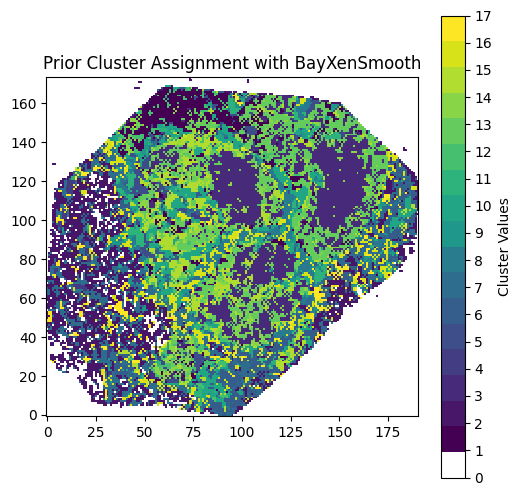

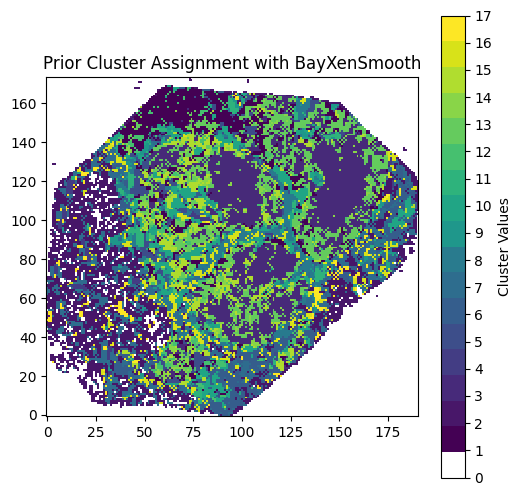

In [54]:
# Clamping
MIN_CONCENTRATION = 0.001

num_posterior_samples = 100

spatial_init_data = StandardScaler().fit_transform(gene_data)
gene_data = StandardScaler().fit_transform(gene_data)
empirical_prior_means = torch.zeros(num_clusters, spatial_init_data.shape[1])
empirical_prior_scales = torch.ones(num_clusters, spatial_init_data.shape[1])

rows = spatial_locations["row"].astype(int)
columns = spatial_locations["col"].astype(int)

num_rows = max(rows) + 1
num_cols = max(columns) + 1

if custom_init or kmeans_init:

    if custom_init:

        initial_clusters = custom_cluster_initialization(original_adata, custom_init)

    elif kmeans_init:

        kmeans_init_data = np.concatenate((spatial_locations, original_adata.xenium_spot_data.X), axis=1)
        kmeans_init_data = StandardScaler().fit_transform(kmeans_init_data)

        if spatial_normalize:

            spatial_dim = spatial_locations.shape[1]
            gene_dim = original_adata.xenium_spot_data.X.shape[1]
            spatial_factor = (gene_dim * spatial_normalize / (spatial_dim * (1 - spatial_normalize))) ** 0.5
            kmeans_init_data[:, :spatial_locations.shape[1]] *= spatial_factor

        kmeans = KMeans(n_clusters=num_clusters).fit(kmeans_init_data)

        initial_clusters = kmeans.predict(kmeans_init_data)

    match data_mode:
        case "PCA":
            data_file_path = f"{data_mode}/{num_pcs}"
        case "HVG": 
            data_file_path = f"{data_mode}/{hvg_var_prop}"
        case "ALL":
            data_file_path = f"{data_mode}"
        case _:
            raise ValueError("The data mode specified is not supported.")
        
    if kmeans_init and not custom_init:

        if not os.path.exists(kmeans_clusters_filepath := save_filepath("KMeans", "clusters")):
            os.makedirs(kmeans_clusters_filepath)
        _ = plt.savefig(
            f"{kmeans_clusters_filepath}/result.png"
        )

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.int)
        
        cluster_grid[rows, columns] = torch.tensor(initial_clusters, dtype=torch.int) + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        plt.title('Cluster Assignment with KMeans')

    if dataset_name == "DLPFC":
        # Create a DataFrame for easier handling
        data = pd.DataFrame({
            'ClusterAssignments': initial_clusters,
            'Region': original_adata.xenium_spot_data.obs["Region"]
        })

        # Drop rows where 'Region' is NaN
        filtered_data = data.dropna(subset=['Region'])

        # Calculate ARI and NMI only for the non-NaN entries
        ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        cluster_metrics = {
            "ARI": ari,
            "NMI": nmi
        }

        data_file_path = f"{data_mode}/{num_pcs}"

        if not os.path.exists(kmeans_cluster_metrics_filepath := save_filepath("KMeans", "cluster_metrics")):
            os.makedirs(kmeans_cluster_metrics_filepath)
        with open(f"{kmeans_cluster_metrics_filepath}/wss.json", 'w') as fp:
            json.dump(cluster_metrics, fp)

    for i in range(num_clusters):
        cluster_data = gene_data[initial_clusters == i]
        if cluster_data.size > 0:  # Check if there are any elements in the cluster_data
            empirical_prior_means[i] = torch.tensor(cluster_data.mean(axis=0))
            empirical_prior_scales[i] = torch.tensor(cluster_data.std(axis=0))
    cluster_probs_prior = torch.zeros((initial_clusters.shape[0], num_clusters))
    cluster_probs_prior[torch.arange(initial_clusters.shape[0]), initial_clusters - 1] = 1.

else:

    cluster_probs_prior = torch.ones((len(gene_data), num_clusters), dtype=float)

locations_tensor = torch.tensor(spatial_locations.to_numpy())

# Compute the number of elements in each dimension
num_spots = cluster_probs_prior.shape[0]

# Initialize an empty tensor for spatial concentration priors
spatial_cluster_probs_prior = torch.zeros_like(cluster_probs_prior, dtype=torch.float64)

spot_locations = KDTree(locations_tensor.cpu())  # Ensure this tensor is in host memory
neighboring_spot_indexes = spot_locations.query_ball_point(locations_tensor.cpu(), r=neighborhood_size, p=1, workers=8)

# Iterate over each spot
for i in tqdm(range(num_spots)):

    # Select priors in the neighborhood
    priors_in_neighborhood = cluster_probs_prior[neighboring_spot_indexes[i]]
    # print(f"Spot {i} has {len(neighboring_spot_indexes[i])} neighbors")
    # print(priors_in_neighborhood)

    # Compute the sum or mean, or apply a custom weighting function
    if neighborhood_agg == "mean":
        neighborhood_priors = priors_in_neighborhood.mean(dim=0)
    else:
        locations = original_adata.xenium_spot_data.obs[["x_location", "y_location", "z_location"]].values
        neighboring_locations = locations[neighboring_spot_indexes[i]].astype(float)
        distances = torch.tensor(np.linalg.norm(neighboring_locations - locations[i], axis=1))
        def distance_weighting(x):
            weight = 1/(1 + x/spot_size)
            # print(weight)
            return weight / weight.sum()
        neighborhood_priors = (priors_in_neighborhood * distance_weighting(distances).reshape(-1, 1)).sum(dim=0)
    # Update the cluster probabilities
    spatial_cluster_probs_prior[i] += neighborhood_priors

spatial_cluster_probs_prior = spatial_cluster_probs_prior.clamp(MIN_CONCENTRATION)
sample_for_assignment_options = [True, False]

num_prior_samples = 100
for sample_for_assignment in sample_for_assignment_options:

    if sample_for_assignment:
        cluster_assignments_prior_TRUE = pyro.sample("cluster_assignments", dist.Categorical(spatial_cluster_probs_prior).expand_by([num_prior_samples])).detach().mode(dim=0).values
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_assignments_prior_FALSE = spatial_cluster_probs_prior.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE

    # Load the data
    data = torch.tensor(gene_data).float()

    cluster_grid_PRIOR = torch.zeros((num_rows, num_cols), dtype=torch.long)

    cluster_grid_PRIOR[rows, columns] = cluster_assignments_prior + 1

    colors = plt.cm.get_cmap('viridis', num_clusters + 1)
    
    colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
    colormap = ListedColormap(colormap_colors)

    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_grid_PRIOR.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
    plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
    plt.title('Prior Cluster Assignment with BayXenSmooth')

    if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
        os.makedirs(bayxensmooth_clusters_filepath)
    _ = plt.savefig(
        f"{bayxensmooth_clusters_filepath}/prior_result.png"
    )

In [55]:
# grab the WSS distance of cluster labels
wss = {}
for label in range(1, num_clusters + 1):
    current_cluster_locations = torch.stack(torch.where((cluster_grid_PRIOR.cpu() == label)), axis=1).to(float)
    wss[f"Cluster {label}"] = (spot_size ** 2) * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()
sum(wss.values()) / 1_000_000

2.9025590261573058

In [56]:
empirical_prior_means_guide = empirical_prior_means.clone().detach()
empirical_prior_scales_guide = empirical_prior_scales.clone().detach()

In [57]:
torch.softmax(torch.log(spatial_cluster_probs_prior), dim=1)

tensor([[0.0010, 0.9843, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.3284, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.7389, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        ...,
        [0.0010, 0.9843, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.7389, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.6568, 0.0010,  ..., 0.0010, 0.0010, 0.0010]],
       dtype=torch.float64)

In [58]:
spatial_cluster_probs_prior.shape

torch.Size([23444, 17])

In [59]:
torch.set_printoptions(sci_mode=False)
PRIOR_SCALE = np.sqrt(0.1) # higher means weaker
NUM_PARTICLES = 25

expected_total_param_dim = 2 # K x D

def model(data):

    with pyro.plate("clusters", num_clusters):

        # Define the means and variances of the Gaussian components
        cluster_means = pyro.sample("cluster_means", dist.Normal(empirical_prior_means, 1.0).to_event(1))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(empirical_prior_scales, 0.25).to_event(1))

    # Define priors for the cluster assignment probabilities and Gaussian parameters
    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:
        batch_data = data[ind]
        mu = torch.log(spatial_cluster_probs_prior[ind])
        cov_matrix = torch.eye(mu.shape[1], dtype=mu.dtype, device=mu.device) * 10.0
        cluster_probs_logits = pyro.sample("cluster_logits", dist.MultivariateNormal(mu, cov_matrix))
        cluster_probs = torch.softmax(cluster_probs_logits, dim=-1)
        # likelihood for batch
        if cluster_means.dim() == expected_total_param_dim:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(0).expand(batch_size, -1, -1), 
                    cluster_scales.unsqueeze(0).expand(batch_size, -1, -1), +
                    cluster_probs
                ), 
                obs=batch_data
            )
        # likelihood for batch WITH vectorization of particles
        else:
            pyro.sample(f"obs", dist.MixtureOfDiagNormals(
                    cluster_means.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_scales.unsqueeze(1).expand(-1, batch_size, -1, -1), 
                    cluster_probs
                ), 
                obs=batch_data
            )

def guide(data):
    # Initialize cluster assignment probabilities for the entire dataset
    cluster_probs_logits_q_mean = pyro.param("cluster_logits_q_mean", torch.log(spatial_cluster_probs_prior) + torch.randn_like(spatial_cluster_probs_prior) * 0.1)
    cluster_probs_logits_q_scale = pyro.param("cluster_logits_q_scale", torch.ones_like(spatial_cluster_probs_prior, dtype=spatial_cluster_probs_prior.dtype, device=spatial_cluster_probs_prior.device) * 2.5, dist.constraints.positive)

    with pyro.plate("clusters", num_clusters):
        # Global variational parameters for means and scales
        cluster_means_q = pyro.param("cluster_means_q", empirical_prior_means + torch.randn_like(empirical_prior_means) * 0.05)
        cluster_scales_q = pyro.param("cluster_scales_q", empirical_prior_scales + torch.randn_like(empirical_prior_scales) * 0.01, constraint=dist.constraints.positive)
        cluster_means = pyro.sample("cluster_means", dist.Normal(cluster_means_q, 1.0).to_event(1))
        cluster_scales = pyro.sample("cluster_scales", dist.LogNormal(cluster_scales_q, 0.1).to_event(1))

    with pyro.plate("data", len(data), subsample_size=batch_size) as ind:

        batch_probs_logits_q_mean = cluster_probs_logits_q_mean[ind]
        batch_probs_logits_q_scale = cluster_probs_logits_q_scale[ind]
        logits = pyro.sample("cluster_logits", dist.Normal(batch_probs_logits_q_mean, batch_probs_logits_q_scale).to_event(1))
        cluster_probs = torch.softmax(logits, dim=-1)  # Convert logits to probabilities

In [60]:
empirical_prior_means.shape, empirical_prior_scales.shape

(torch.Size([17, 3]), torch.Size([17, 3]))

In [61]:
print(pyro.render_model(model, model_args=(data,), render_distributions=True, render_params=True))

digraph {
	subgraph cluster_clusters {
		label=clusters labeljust=r labelloc=b
		cluster_means [label=cluster_means fillcolor=white shape=ellipse style=filled]
		cluster_scales [label=cluster_scales fillcolor=white shape=ellipse style=filled]
	}
	subgraph cluster_data {
		label=data labeljust=r labelloc=b
		cluster_logits [label=cluster_logits fillcolor=white shape=ellipse style=filled]
		obs [label=obs fillcolor=gray shape=ellipse style=filled]
	}
	cluster_means -> obs
	cluster_scales -> obs
	cluster_logits -> obs
	distribution_description_node [label="cluster_means ~ Normal\lcluster_scales ~ LogNormal\lcluster_logits ~ MultivariateNormal\lobs ~ MixtureOfDiagNormals\l" shape=plaintext]
}



In [62]:
pyro.clear_param_store()
NUM_EPOCHS = 250
NUM_BATCHES = int(math.ceil(data.shape[0] / batch_size))

def per_param_callable(param_name):
    if param_name == 'cluster_means_q':
        return {"lr": 0.0005, "betas": (0.9, 0.999)}
    elif param_name == 'cluster_scales_q':
        return {"lr": 0.0001, "betas": (0.9, 0.999)}
    else:
        return {"lr": 0.01, "betas": (0.9, 0.999)}

scheduler = Adam(per_param_callable)

# Setup the inference algorithm
svi = SVI(model, guide, scheduler, loss=TraceMeanField_ELBO(num_particles=NUM_PARTICLES, vectorize_particles=True))

# Create a DataLoader for the data
# Convert data to CUDA tensors before creating the DataLoader
data = data.to('cuda')

# Clear the param store in case we're in a REPL
pyro.clear_param_store()

epoch_pbar = tqdm(range(NUM_EPOCHS))
cluster_means_trace = []
cluster_scales_trace = []
current_min_loss = float('inf')
PATIENCE = 10
patience_counter = 0
for epoch in epoch_pbar:
    epoch_pbar.set_description(f"Epoch {epoch}")
    running_loss = 0.0
    for step in range(NUM_BATCHES):
        loss = svi.step(data)
        running_loss += loss / batch_size
        # running_loss += (loss + SPATIAL_PENALTY_WEIGHT * spatial_penalty()) / batch_size
    # svi.optim.step()
    if epoch % 1 == 0:
        print(f"Epoch {epoch} : loss = {round(running_loss, 4)}")
        current_cluster_means = pyro.param("cluster_means_q").detach().cpu().numpy()
        cluster_means_trace.append(current_cluster_means)
        current_cluster_scales = pyro.param("cluster_scales_q").detach().cpu().numpy()
        cluster_scales_trace.append(current_cluster_scales)
        # print(current_cluster_means[0])
        if running_loss > current_min_loss:
            patience_counter += 1
        else:
            current_min_loss = running_loss
            patience_counter = 0
        if patience_counter >= PATIENCE:
            break 
        l2_norm = torch.norm(torch.softmax(pyro.param("cluster_logits_q_mean").detach(), dim=-1) - spatial_cluster_probs_prior, p=2)
        print(torch.softmax(pyro.param("cluster_logits_q_mean").detach(), dim=-1)[0])
        # cluster_concentration_params_q = pyro.param("cluster_concentration_params_q", concentration_priors, constraint=dist.constraints.positive).clamp(min=MIN_CONCENTRATION)
        # if sample_for_assignment:
        #     cluster_probs_q = pyro.sample("cluster_probs", dist.Dirichlet(cluster_concentration_params_q, validate_args=True)).detach()     
        # else:
        #     # the probs aren't sampled and we calculate the EV instead
        #     cluster_probs_q = (cluster_concentration_params_q / cluster_concentration_params_q.sum(dim=1, keepdim=True))
        # cluster_assignments_q = cluster_probs_q.argmax(dim=1)

        # if dataset_name == "DLPFC":
        #     # Create a DataFrame for easier handling
        #     cluster_data = pd.DataFrame({
        #         'ClusterAssignments': cluster_assignments_q,
        #         'Region': original_adata.xenium_spot_data.obs["Region"]
        #     })

        #     # Drop rows where 'Region' is NaN
        #     filtered_data = cluster_data.dropna(subset=['Region'])

        #     # Calculate ARI and NMI only for the non-NaN entries
        #     ari = ARI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        #     nmi = NMI(filtered_data['ClusterAssignments'], filtered_data['Region'])
        #     print(f"Step {step} : ARI = {ari} NMI = {nmi}")

Epoch 1:   0%|          | 1/250 [00:00<03:18,  1.26it/s]

Epoch 0 : loss = 12811.9823
tensor([    0.0011,     0.9833,     0.0011,     0.0012,     0.0011,     0.0010,
            0.0010,     0.0010,     0.0010,     0.0010,     0.0011,     0.0010,
            0.0010,     0.0009,     0.0011,     0.0010,     0.0010],
       dtype=torch.float64)


Epoch 2:   1%|          | 2/250 [00:01<03:11,  1.30it/s]

Epoch 1 : loss = 12262.7067
tensor([    0.0010,     0.9835,     0.0011,     0.0012,     0.0010,     0.0010,
            0.0010,     0.0010,     0.0010,     0.0010,     0.0010,     0.0010,
            0.0011,     0.0009,     0.0010,     0.0011,     0.0011],
       dtype=torch.float64)


Epoch 3:   1%|          | 3/250 [00:02<03:07,  1.32it/s]

Epoch 2 : loss = 11784.3349
tensor([0.0011, 0.9830, 0.0011, 0.0011, 0.0010, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0010, 0.0011, 0.0011, 0.0010, 0.0011, 0.0011, 0.0011],
       dtype=torch.float64)


Epoch 4:   2%|▏         | 4/250 [00:03<03:04,  1.33it/s]

Epoch 3 : loss = 11504.0494
tensor([0.0010, 0.9835, 0.0011, 0.0011, 0.0011, 0.0010, 0.0010, 0.0011, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010],
       dtype=torch.float64)


Epoch 5:   2%|▏         | 5/250 [00:03<03:02,  1.34it/s]

Epoch 4 : loss = 11318.9158
tensor([0.0010, 0.9834, 0.0011, 0.0011, 0.0010, 0.0011, 0.0010, 0.0011, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011, 0.0011],
       dtype=torch.float64)


Epoch 6:   2%|▏         | 6/250 [00:04<03:01,  1.35it/s]

Epoch 5 : loss = 11235.1565
tensor([0.0010, 0.9834, 0.0011, 0.0011, 0.0010, 0.0011, 0.0010, 0.0011, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011, 0.0011],
       dtype=torch.float64)


Epoch 7:   3%|▎         | 7/250 [00:05<02:59,  1.35it/s]

Epoch 6 : loss = 11174.783
tensor([0.0010, 0.9831, 0.0011, 0.0011, 0.0011, 0.0010, 0.0010, 0.0011, 0.0010,
        0.0010, 0.0011, 0.0010, 0.0010, 0.0010, 0.0011, 0.0011, 0.0010],
       dtype=torch.float64)


Epoch 8:   3%|▎         | 8/250 [00:05<02:58,  1.36it/s]

Epoch 7 : loss = 11131.055
tensor([    0.0010,     0.9837,     0.0010,     0.0010,     0.0010,     0.0010,
            0.0011,     0.0011,     0.0010,     0.0010,     0.0010,     0.0010,
            0.0010,     0.0010,     0.0010,     0.0010,     0.0011],
       dtype=torch.float64)


Epoch 9:   4%|▎         | 9/250 [00:06<02:57,  1.36it/s]

Epoch 8 : loss = 11107.1326
tensor([0.0011, 0.9829, 0.0011, 0.0011, 0.0011, 0.0010, 0.0011, 0.0011, 0.0010,
        0.0010, 0.0011, 0.0010, 0.0011, 0.0011, 0.0011, 0.0011, 0.0010],
       dtype=torch.float64)


Epoch 10:   4%|▍         | 10/250 [00:07<02:57,  1.35it/s]

Epoch 9 : loss = 11087.4432
tensor([    0.0010,     0.9846,     0.0010,     0.0010,     0.0009,     0.0010,
            0.0010,     0.0010,     0.0010,     0.0010,     0.0010,     0.0010,
            0.0009,     0.0010,     0.0009,     0.0010,     0.0010],
       dtype=torch.float64)


Epoch 11:   4%|▍         | 11/250 [00:08<02:57,  1.35it/s]

Epoch 10 : loss = 11069.2794
tensor([    0.0010,     0.9846,     0.0010,     0.0010,     0.0009,     0.0010,
            0.0010,     0.0010,     0.0010,     0.0010,     0.0010,     0.0010,
            0.0009,     0.0010,     0.0009,     0.0010,     0.0010],
       dtype=torch.float64)


Epoch 12:   5%|▍         | 12/250 [00:08<02:56,  1.35it/s]

Epoch 11 : loss = 11029.3209
tensor([    0.0010,     0.9846,     0.0009,     0.0010,     0.0009,     0.0010,
            0.0010,     0.0010,     0.0010,     0.0010,     0.0010,     0.0010,
            0.0010,     0.0010,     0.0009,     0.0010,     0.0010],
       dtype=torch.float64)


Epoch 13:   5%|▌         | 13/250 [00:09<02:56,  1.34it/s]

Epoch 12 : loss = 11017.8448
tensor([0.0010, 0.9829, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0010, 0.0011, 0.0010, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011],
       dtype=torch.float64)


Epoch 13:   5%|▌         | 13/250 [00:09<03:00,  1.31it/s]


KeyboardInterrupt: 

In [ ]:
torch.abs(pyro.param("cluster_means_q").detach() - empirical_prior_means).mean()

In [ ]:
pyro.param("cluster_means_q").detach(), empirical_prior_means

In [ ]:
# cluster_means_trace = np.array(cluster_means_trace)  # Shape: [num_epochs, num_clusters, data_dim]
# import matplotlib.pyplot as plt

# num_epochs, num_clusters, data_dim = cluster_means_trace.shape

# for cluster_idx in range(num_clusters):
#     for dim_idx in range(data_dim):
#         plt.plot(
#             range(num_epochs),
#             cluster_means_trace[:, cluster_idx, dim_idx],
#             label=f"Cluster {cluster_idx}, Dim {dim_idx}"
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel("Cluster Mean Value")
#         plt.title(f"Trace Plot for Cluster {cluster_idx}, Dimension {dim_idx}")
#         plt.legend()
#         plt.show()
#         break


In [ ]:
# cluster_scales_trace = np.array(cluster_scales_trace)  # Shape: [num_epochs, num_clusters, data_dim]
# import matplotlib.pyplot as plt

# num_epochs, num_clusters, data_dim = cluster_scales_trace.shape

# for cluster_idx in range(num_clusters):
#     for dim_idx in range(data_dim):
#         plt.plot(
#             range(num_epochs),
#             cluster_scales_trace[:, cluster_idx, dim_idx],
#             label=f"Cluster {cluster_idx}, Dim {dim_idx}"
#         )
#         plt.xlabel("Epoch")
#         plt.ylabel("Cluster Scale Value")
#         plt.title(f"Trace Plot for Cluster {cluster_idx}, Dimension {dim_idx}")
#         plt.legend()
#         plt.show()
#         break

tensor(1, device='cuda:5')
<class 'torch.Tensor'> torch.int64
<class 'torch.Tensor'>
0.5591622591018677
WSS 2.95927306284935
Loading data.
Number of spots:  23444
Number of spots after filtering:  23444
BXS MORAN True
Starting Moran's I Calculation.
Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 1.0860411450010172
100 CEACAM6 0.38622204134340665
100 FASN 1.0641272713450085
100 FGL2 0.4769291073504045
100 IL7R 0.9478018156231689
100 KRT6B 0.3228198532921226
100 POSTN 0.4608497914405811
100 TCIM 0.41595320207841235
{'BANK1': 1.0860411450010172, 'CEACAM6': 0.38622204134340665, 'FASN': 1.0641272713450085, 'FGL2': 0.4769291073504045, 'IL7R': 0.9478018156231689, 'KRT6B': 0.3228198532921226, 'POSTN': 0.4608497914405811, 'TCIM': 0.41595320207841235}
INITIAL MORAN True
Starting Moran's I Calculation.
Neighbors calculated.
(23444, 23444) (23444, 23444)
Connectivities formed.
100 BANK1 1.465989990230378
100 CEACAM6 0.39993573995772447
100 FASN 1.1673672467211

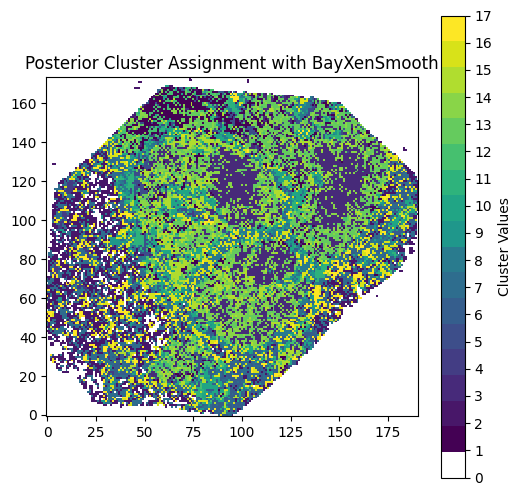

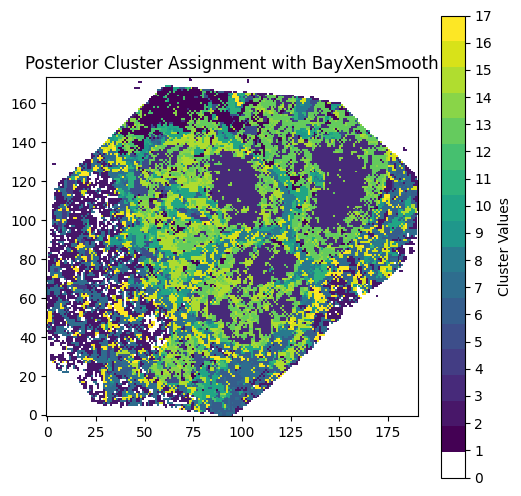

In [80]:
torch.set_default_tensor_type(torch.FloatTensor)

# Grab the learned variational parameters
num_posterior_samples = 10
sample_for_assignment_options = [True, False]

for sample_for_assignment in sample_for_assignment_options:
    cluster_logits_q_mean = pyro.param("cluster_logits_q_mean")
    cluster_logits_q_scale = pyro.param("cluster_logits_q_scale")
    if sample_for_assignment:
        cluster_probs_q = torch.softmax(pyro.sample("cluster_probs", dist.Normal(cluster_logits_q_mean, cluster_logits_q_scale).expand_by([num_posterior_samples]).to_event(1)).mean(dim=0), dim=-1)
        cluster_assignments_q = pyro.sample("cluster_assignments", dist.Categorical(cluster_probs_q).expand_by([num_posterior_samples])).mode(dim=0).values
        print(cluster_assignments_q[0])
        cluster_assignments_prior = cluster_assignments_prior_TRUE
    else:
        cluster_probs_q = torch.softmax(cluster_logits_q_mean, dim=-1)
        cluster_assignments_q = cluster_probs_q.argmax(dim=1)
        cluster_assignments_prior = cluster_assignments_prior_FALSE
    
    cluster_means_q = pyro.param("cluster_means_q").cpu().detach()
    cluster_scales_q = pyro.param("cluster_scales_q").cpu().detach()
    cluster_probs_q = cluster_probs_q.cpu().detach()
    cluster_assignments_q = cluster_assignments_q.cpu().detach()
    cluster_assignments_prior = cluster_assignments_prior.cpu().detach()

    # Plotting
    if spot_size:

        rows = spatial_locations["row"].astype(int)
        columns = spatial_locations["col"].astype(int)

        num_rows = max(rows) + 1
        num_cols = max(columns) + 1

        cluster_grid = torch.zeros((num_rows, num_cols), dtype=torch.long)

        cluster_grid[rows, columns] = cluster_assignments_q + 1

        colors = plt.cm.get_cmap('viridis', num_clusters + 1)

        colormap_colors = np.vstack(([[1, 1, 1, 1]], colors(np.linspace(0, 1, num_clusters))))
        colormap = ListedColormap(colormap_colors)

        plt.figure(figsize=(6, 6))
        plt.imshow(cluster_grid.cpu(), cmap=colormap, interpolation='nearest', origin='lower')
        plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        plt.title('Posterior Cluster Assignment with BayXenSmooth')

        match data_mode:
            case "PCA":
                data_file_path = f"{data_mode}/{num_pcs}"
            case "HVG": 
                data_file_path = f"{data_mode}/{hvg_var_prop}"
            case "ALL":
                data_file_path = f"{data_mode}"
            case _:
                raise ValueError("The data mode specified is not supported.")

        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )

        clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"]).to_csv(f"{bayxensmooth_clusters_filepath}/clusters_K={num_clusters}.csv")
        soft_clusters = pd.DataFrame(cluster_probs_q, columns=[f'P(z_i = {i})'  for i in range(1, num_clusters + 1)]).to_csv(f"{bayxensmooth_clusters_filepath}/soft_clusters_K={num_clusters}.csv")

        if not os.path.exists(bayxensmooth_similar_filepath := save_filepath("BayXenSmooth", "prior_v_posterior", sample_for_assignment)):
            os.makedirs(bayxensmooth_similar_filepath)
        with open(f"{bayxensmooth_similar_filepath}/similarity.txt", 'w') as fp:
            prior_similarity = torch.mean((cluster_assignments_prior == cluster_assignments_q).float()).item()
            fp.write(str(prior_similarity))
            print(prior_similarity)

        # grab the WSS distance of cluster labels
        wss = {}
        for label in range(1, num_clusters + 1):
            current_cluster_locations = torch.stack(torch.where((cluster_grid.cpu() == label)), axis=1).to(float)
            wss[f"Cluster {label}"] = (spot_size ** 2) * torch.mean(torch.cdist(current_cluster_locations, current_cluster_locations, p = 2)).item()
        print("WSS", sum(wss.values()) / 1_000_000)

        if not os.path.exists(bayxensmooth_wss_filepath := save_filepath("BayXenSmooth", "wss", sample_for_assignment)):
            os.makedirs(bayxensmooth_wss_filepath)
        with open(f"{bayxensmooth_wss_filepath}/wss.json", 'w') as fp:
            json.dump(wss, fp)

        cmap = get_cmap('rainbow')

        if isinstance(original_adata.xenium_spot_data.X, csr_matrix):
            labels = np.unique(cluster_assignments_q)  # Define the number of clusters
            gene_columns = original_adata.xenium_spot_data.var.index  # Column names from another source
            mean_expression_by_cluster = pd.DataFrame(columns=gene_columns)

            # Loop through each cluster label
            for label in labels:
                # Find indexes of current cluster
                current_cluster_indexes = torch.where(cluster_assignments_q == label)[0].numpy()
                
                # Efficiently extract the rows for the current cluster using fancy indexing
                expressions = original_adata.xenium_spot_data.X[current_cluster_indexes, :]
                print(label, expressions.shape)
                
                # Compute mean expressions; the result is still a csr_matrix
                mean_expressions = expressions.mean(axis=0)
                
                # Convert mean_expressions to a dense format and then to a DataFrame
                mean_expressions_df = pd.DataFrame(mean_expressions.A, columns=gene_columns)
                
                # Append the result to the mean_expression_by_cluster DataFrame
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions_df], ignore_index=True)
        else:
            # identify marker genes within each cluster
            mean_expression_by_cluster = pd.DataFrame(columns=original_adata.xenium_spot_data.var.index)

            for label in range(num_clusters):
                current_cluster_indexes = list(torch.where(cluster_assignments_q == label)[0].cpu().numpy())
                expressions = pd.DataFrame(original_adata.xenium_spot_data.X, columns=original_adata.xenium_spot_data.var.index).iloc[current_cluster_indexes, :]
                mean_expressions = expressions.mean(axis=0).to_frame().T
                mean_expression_by_cluster = pd.concat([mean_expression_by_cluster, mean_expressions], ignore_index=True)

        if evaluate_markers:
            for i, gene in enumerate(mean_expression_by_cluster.columns):
                # using subplots() to draw vertical lines 
                fig, ax = plt.subplots(figsize=(6, 6)) 
                ax.vlines(mean_expression_by_cluster[gene].index, ymin=0, ymax=mean_expression_by_cluster[gene], color=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                
                # drawing the markers
                ax.plot(mean_expression_by_cluster[gene].index, mean_expression_by_cluster[gene], "^", c=cmap(i / (len(mean_expression_by_cluster.columns) - 1))) 
                ax.set_ylim(0) 
                
                # formatting and details 
                ax.set_xlabel('Cluster Label') 
                ax.set_ylabel('Mean Expression') 
                ax.set_title(gene) 
                ax.set_xticks(mean_expression_by_cluster[gene].index) 
                if not os.path.exists(bayxensmooth_expression_filepath := save_filepath("BayXenSmooth", "expressions", sample_for_assignment)):
                    os.makedirs(f"{bayxensmooth_expression_filepath}")
                _ = plt.savefig(
                    f"{bayxensmooth_expression_filepath}/GENE={gene}.png"
                )
        
        # confidence mapping
        cluster_confidences = torch.zeros((num_rows, num_cols), dtype=torch.double)

        cluster_confidences[rows, columns] = cluster_probs_q.max(dim=1).values

        colors = plt.cm.get_cmap('Greys', num_clusters + 1)
        colormap = ListedColormap(colors(np.linspace(0, 1, num_clusters + 1)))

        # confidence_proportions = {}
        # for uncertainty_value in uncertainty_values:
        #     confidence_matrix = (cluster_confidences > uncertainty_value).float()
        #     confidence_proportions[uncertainty_value] = torch.mean(confidence_matrix).item()
        #     plt.figure(figsize=(6, 6))
        #     plt.imshow(cluster_confidences > uncertainty_value, cmap=colormap, interpolation='nearest', origin='lower')
        #     plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
        #     # PLOT ALL UNCERTAINTY VALUESs
        #     plt.title(r'$P(z_i = k) > $' + f'{uncertainty_value}')
        #     if not os.path.exists(bayxensmooth_uncertainty_filepath := save_filepath("BayXenSmooth", "uncertainty", sample_for_assignment)):
        #         os.makedirs(bayxensmooth_uncertainty_filepath)
        #     _ = plt.savefig(
        #         f"{bayxensmooth_uncertainty_filepath}/CONFIDENCE={uncertainty_value}.png"
        #     )

    else:

        plt.scatter(spatial_locations["x_location"], spatial_locations["y_location"], s=1, c=cluster_assignments_q)
        if not os.path.exists(bayxensmooth_clusters_filepath := save_filepath("BayXenSmooth", "clusters", sample_for_assignment)):
            os.makedirs(bayxensmooth_clusters_filepath)
        _ = plt.savefig(
            f"{bayxensmooth_clusters_filepath}/result.png"
        )
    
    gene_data, spatial_locations, original_adata = prepare_Xenium_data(
        dataset="hBreast", 
        spots=True, 
        spot_size=spot_size, 
        third_dim=False, 
        log_normalize=False, 
        likelihood_mode=data_mode, 
        num_pcs=num_pcs,
        hvg_var_prop=hvg_var_prop,
        min_expressions_per_spot=0
    )

    print("BXS MORAN", sample_for_assignment)
    clusters = pd.DataFrame(cluster_assignments_q.cpu(), columns=["BayXenSmooth cluster"])
    morans_i_gene_dict = gene_morans_i(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    # gearys_c_gene_dict = gene_gearys_c(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    marker_genes = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]
    morans_i_markers = {k: v for k, v in morans_i_gene_dict.items() if k in marker_genes}
    # gearys_c_markers = {k: v for k, v in gearys_c_gene_dict.items() if k in marker_genes}
    print(morans_i_markers)

    print("INITIAL MORAN", sample_for_assignment)
    clusters = pd.DataFrame(initial_clusters, columns=["initial cluster"])
    morans_i_gene_dict = gene_morans_i(original_adata, spatial_locations, clusters["initial cluster"])
    # gearys_c_gene_dict = gene_gearys_c(original_adata, spatial_locations, clusters["BayXenSmooth cluster"])
    marker_genes = ["BANK1", "CEACAM6", "FASN", "FGL2", "IL7R", "KRT6B", "POSTN", "TCIM"]
    morans_i_markers = {k: v for k, v in morans_i_gene_dict.items() if k in marker_genes}
    # gearys_c_markers = {k: v for k, v in gearys_c_gene_dict.items() if k in marker_genes}

    print(morans_i_markers)

In [ ]:
(torch.softmax(pyro.param("cluster_logits_q").detach(), dim=1).argmax(dim=1) == spatial_cluster_probs_prior.argmax(dim=1)).float().mean()

In [ ]:
plt.figure(figsize=(6, 6))
same_labels = cluster_grid_PRIOR.cpu() == cluster_grid.cpu()
plt.imshow(same_labels, interpolation='nearest', origin='lower')
plt.colorbar(ticks=range(num_clusters + 1), label='Cluster Values')
print(f"Proportion of Same Labels: {same_labels.float().mean()}")
_ = plt.title('Initial Clustering')